In [1]:
# Import necessary libraries
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import dowhy
from dowhy import CausalModel
import re
from collections import Counter



def load_data(filepath):
    df = pd.read_csv(filepath, header=None, skiprows=0)
    df.columns = df.iloc[0]
    df = df[1:]
    return df



# Load and preprocess data
file_path = r"C:\Users\nstep\TSU\SeniorProject\nashvilleDF.csv"
nashvilleDF = load_data(file_path)

#nashvilleDf to lower case

nashvilleDF.head()

#check to see if nashvilleDF has a column named 'id' and show results for 5 rows
nashvilleDF['id'].head()

C:\Users\nstep\AppData\Local\Temp\ipykernel_15064\596880472.py:21: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244) have mixed types. Specify dtype option on impo

1      6422
2     39870
3     72906
4    258817
5    289242
Name: id, dtype: object

In [2]:
#calculate the number of of rows that have 1 in the column 'wifi' in nashvilleDF
nashvilleDF['wifi'].astype(int).value_counts()



1    8524
0      56
Name: wifi, dtype: int64

In [3]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, KFold
from joblib import Parallel, delayed
import numpy as np

def process_fold(fold, train_index, test_index, X, y):
    model = HistGradientBoostingRegressor()
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    sorted_idx = perm_importance.importances_mean.argsort()[::-1]
    sorted_features = [(X.columns[i], perm_importance.importances_mean[i]) for i in sorted_idx]
    return score, perm_importance.importances_mean, sorted_features

# Assuming nashvilleDF is defined
X = nashvilleDF.drop(['price', 'id'], axis=1)
y = nashvilleDF['price']
X.columns = X.columns.astype(str)

num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
scores = np.zeros(num_folds)
feature_importances = np.zeros((num_folds, X.shape[1]))
results = Parallel(n_jobs=-1)(delayed(process_fold)(fold, train_index, test_index, X, y) 
                              for fold, (train_index, test_index) in enumerate(kf.split(X)))

accuracy_scores = []
for fold, (score, importance, sorted_features) in enumerate(results):
    scores[fold] = score
    feature_importances[fold] = importance
    
    # Append the score to accuracy_scores list
    accuracy_scores.append(score)

    print(f'Fold {fold+1}: Accuracy = {scores[fold]}')
    print("Features ranked by importance for fold:", fold+1)
    for name, imp in sorted_features:
        print(f"{name}: {imp}")

# Compute and print the average accuracy and standard deviation across all folds
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
print(f'Average Accuracy: {mean_accuracy}')
print(f'Standard Deviation of Accuracy: {std_accuracy}')

# Compute the average feature importance across all folds
avg_feature_importances = feature_importances.mean(axis=0)

# Get the top 20 features based on average importance
top_features = np.argsort(avg_feature_importances)[-20:]
top_feature_names = X.columns[top_features]
top_feature_importances = avg_feature_importances[top_features]

print("Top 20 Features and their Importances:")
print(list(zip(top_feature_names, top_feature_importances)))


Fold 1: Accuracy = 0.7499895338052974
Features ranked by importance for fold: 1
accommodates: 0.32885646333228724
bathrooms: 0.16945732176904968
neighbourhood_cleansed_num: 0.09012715830847001
minimum_minimum_nights: 0.04853644800419778
bedrooms: 0.02970367876016409
reviews_per_month: 0.028004761112721443
availability_30: 0.023982986253146397
minimum_maximum_nights: 0.015764919591926684
review_scores_location: 0.013712242553228105
pool: 0.01283422440285229
number_of_reviews: 0.011833546626326052
maximum_nights: 0.011051778476227337
beds: 0.010913511185920887
resort access: 0.009388739998226647
free parking: 0.008436810943791385
host_acceptance_rate: 0.007214013427960087
review_scores_rating: 0.006542629304862657
elevator: 0.005872086006397314
prop_Entire home: 0.005827972170313922
host_is_superhost: 0.0052033918637582445
fire extinguisher: 0.0045838343477159985
host_response_rate: 0.004499905395293979
fireplace: 0.004216595934998279
review_scores_cleanliness: 0.0037880420122649917
priv

accommodates: 9.0
bathrooms: 8.0
neighbourhood_cleansed_num: 7.0
minimum_minimum_nights: 6.0
bedrooms: 5.0
reviews_per_month: 4.0
availability_30: 3.0
minimum_maximum_nights: 2.0
pool: 0.0
review_scores_location: 0.0
number_of_reviews: -2.0
maximum_nights: -3.0
beds: -3.0
resort access: -4.0
host_acceptance_rate: -6.0
free parking: -8.0
elevator: -11.0
review_scores_rating: -11.0
prop_Entire home: -15.0
host_is_superhost: -17.0
availability_365: -24.0
private entrance: -34.0
maximum_maximum_nights: -35.0
prop_Private room: -39.0
fire extinguisher: -79.0
bathtub: -99.0
host_response_rate: -137.0
fireplace: -156.0
hot tub: -157.0
cable: -179.0
review_scores_value: -199.0


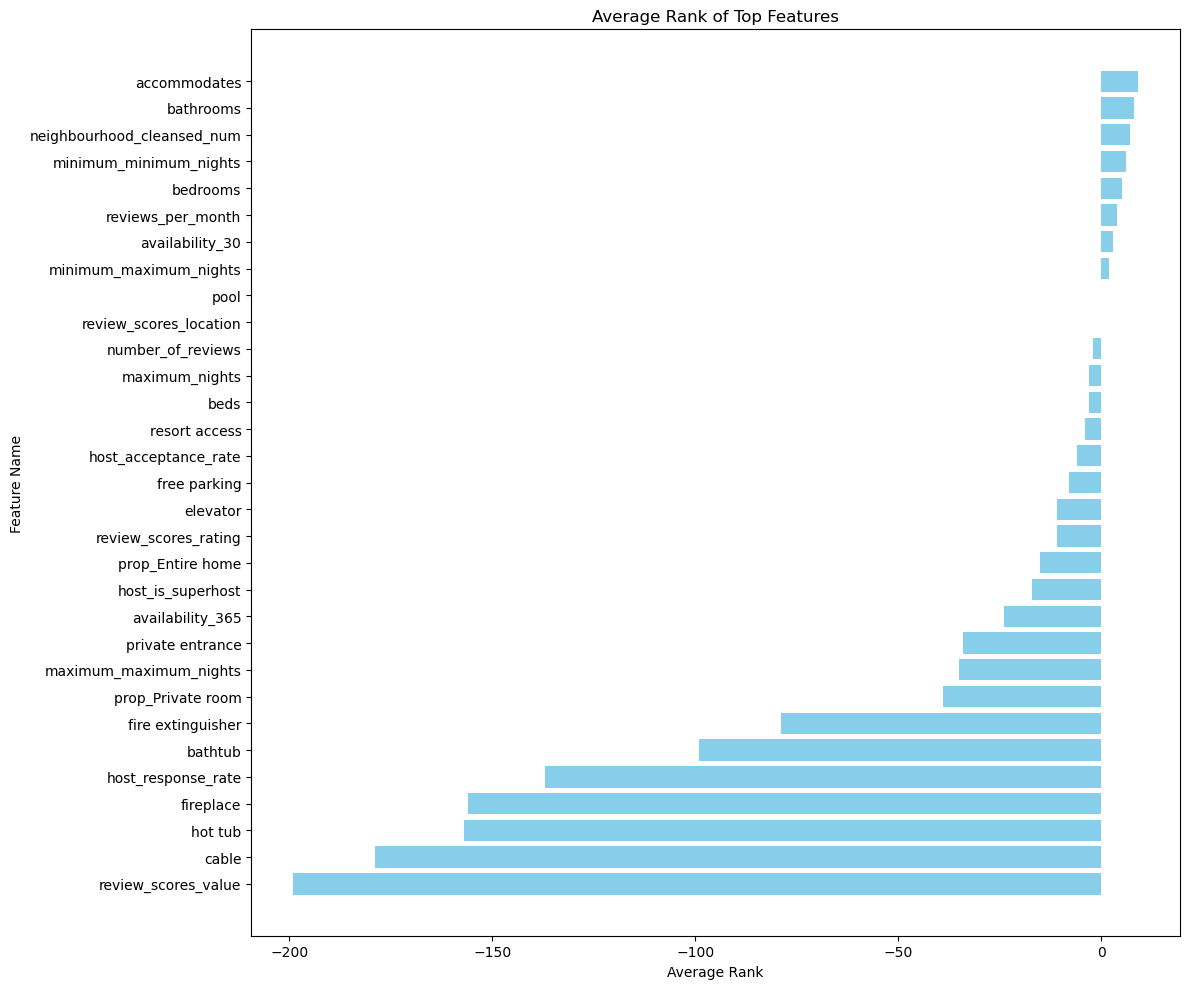

In [4]:
all_top_features = []
for _, _, sorted_features in results:
    top_20 = [feature[0] for feature in sorted_features[:20]]
    all_top_features.extend(top_20)

# Calculate the average rank for each feature
feature_ranks = {feature: 0 for feature in set(all_top_features)}
for feature in all_top_features:
    feature_ranks[feature] += (all_top_features.count(feature) - all_top_features.index(feature) - 1)

average_ranks = {feature: rank / all_top_features.count(feature) for feature, rank in feature_ranks.items()}

# Sort by average rank
sorted_avg_ranks = sorted(average_ranks.items(), key=lambda x: x[1], reverse=True)

# Displaying the sorted average ranks
for feature, rank in sorted_avg_ranks:
    print(f"{feature}: {rank}")

# Plotting the graph
features = [item[0] for item in sorted_avg_ranks]
ranks = [item[1] for item in sorted_avg_ranks]

plt.figure(figsize=(12, 10))
plt.barh(features, ranks, color='skyblue')
plt.xlabel('Average Rank')
plt.ylabel('Feature Name')
plt.title('Average Rank of Top Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [9]:
#print the features of features
print(features)
# Load and preprocess data
file_path = r"C:\Users\nstep\TSU\SeniorProject\nashvilleDF.csv"
nashvilleDF = load_data(file_path)

['accommodates', 'bathrooms', 'neighbourhood_cleansed_num', 'minimum_minimum_nights', 'bedrooms', 'reviews_per_month', 'availability_30', 'minimum_maximum_nights', 'pool', 'review_scores_location', 'number_of_reviews', 'maximum_nights', 'beds', 'resort access', 'host_acceptance_rate', 'free parking', 'elevator', 'review_scores_rating', 'prop_Entire home', 'host_is_superhost', 'availability_365', 'private entrance', 'maximum_maximum_nights', 'prop_Private room', 'fire extinguisher', 'bathtub', 'host_response_rate', 'fireplace', 'hot tub', 'cable', 'review_scores_value', 'prop_Entire condo', 'prop_Entire guest suite', 'prop_Entire guesthouse', 'prop_Entire rental unit', 'prop_Entire townhouse', 'prop_Hotel', 'room_Entire home/apt', 'room_Private room']


C:\Users\nstep\AppData\Local\Temp\ipykernel_15064\596880472.py:21: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244) have mixed types. Specify dtype option on impo

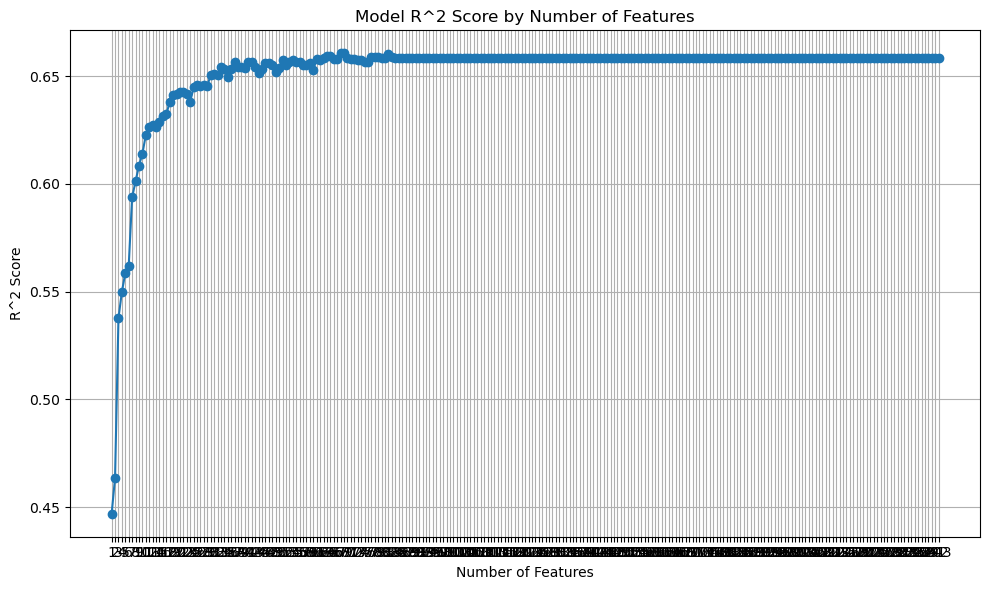

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance  # <-- New import here

def load_data(path):
    return pd.read_csv(path)

def evaluate_with_reduced_parameters(X_train, y_train, X_test, y_test):
    model = HistGradientBoostingRegressor(max_iter=50, max_depth=4)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Load and preprocess data
file_path = r"C:\Users\nstep\TSU\SeniorProject\nashvilleDF.csv"
nashvilleDF = load_data(file_path)

# Splitting the data from the sample
X_sample = nashvilleDF.drop(columns=['price', 'id'])
y_sample = nashvilleDF['price']

# Convert all column names to strings
X_sample.columns = X_sample.columns.astype(str)

X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

# Train the model with all features
model = HistGradientBoostingRegressor(max_iter=50, max_depth=4)
model.fit(X_train_sample, y_train_sample)

# Estimate feature importances using permutation importance
perm_importance = permutation_importance(model, X_train_sample, y_train_sample, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()[::-1]
sorted_features = X_sample.columns[sorted_idx]

# Evaluate the model incrementally adding features
r2_scores = []
for i in range(1, len(sorted_features) + 1):
    selected_features = sorted_features[:i]
    X_train_selected = X_train_sample[selected_features]
    X_test_selected = X_test_sample[selected_features]
    
    r2 = evaluate_with_reduced_parameters(X_train_selected, y_train_sample, X_test_selected, y_test_sample)
    r2_scores.append(r2)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(sorted_features) + 1), r2_scores, marker='o', linestyle='-')
plt.xlabel('Number of Features')
plt.ylabel('R^2 Score')
plt.title('Model R^2 Score by Number of Features')
plt.grid(True)
plt.xticks(range(1, len(sorted_features) + 1))
plt.tight_layout()
plt.show()


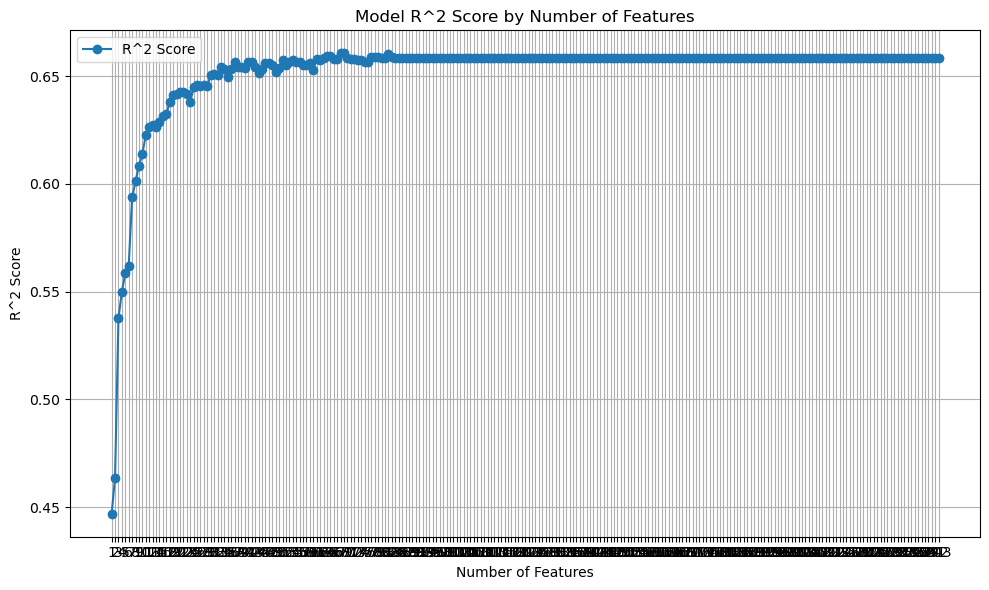

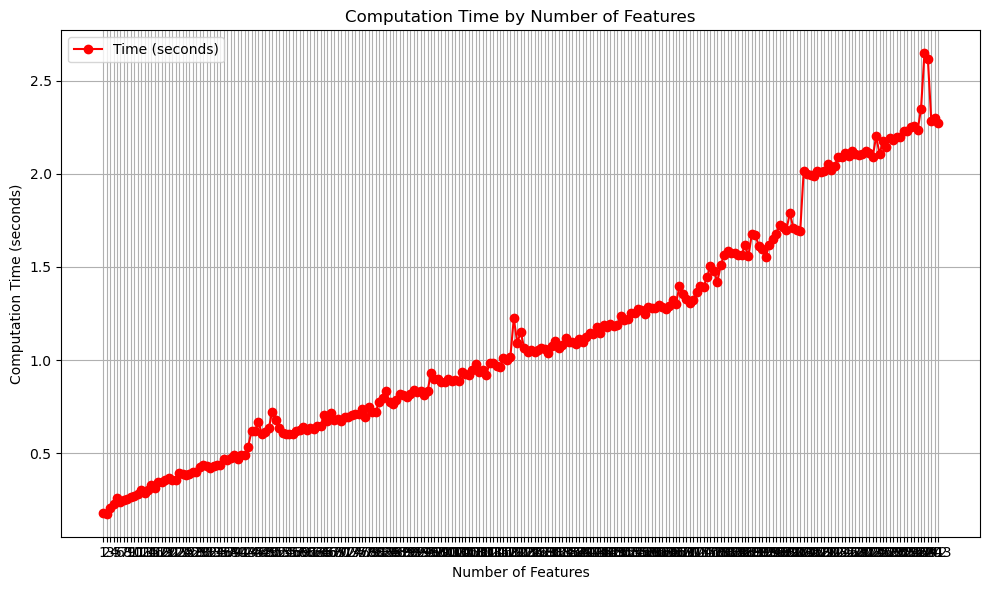

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

def load_data(path):
    return pd.read_csv(path)

def evaluate_with_reduced_parameters(X_train, y_train, X_test, y_test):
    model = HistGradientBoostingRegressor(max_iter=50, max_depth=4)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Load and preprocess data
file_path = r"C:\Users\nstep\TSU\SeniorProject\nashvilleDF.csv"
nashvilleDF = load_data(file_path)

# Splitting the data from the sample
X_sample = nashvilleDF.drop(columns=['price', 'id'])
y_sample = nashvilleDF['price']

# Convert all column names to strings
X_sample.columns = X_sample.columns.astype(str)

X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

# Train the model with all features
model = HistGradientBoostingRegressor(max_iter=50, max_depth=4)
model.fit(X_train_sample, y_train_sample)

# Estimate feature importances using permutation importance
perm_importance = permutation_importance(model, X_train_sample, y_train_sample, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()[::-1]
sorted_features = X_sample.columns[sorted_idx]

# Evaluate the model incrementally adding features
r2_scores = []
times = []

for i in range(1, len(sorted_features) + 1):
    selected_features = sorted_features[:i]
    X_train_selected = X_train_sample[selected_features]
    X_test_selected = X_test_sample[selected_features]
    
    start_time = time.time()
    r2 = evaluate_with_reduced_parameters(X_train_selected, y_train_sample, X_test_selected, y_test_sample)
    end_time = time.time()
    
    elapsed_time = end_time - start_time
    times.append(elapsed_time)
    r2_scores.append(r2)

# Plotting R^2 scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(sorted_features) + 1), r2_scores, marker='o', linestyle='-', label="R^2 Score")
plt.xlabel('Number of Features')
plt.ylabel('R^2 Score')
plt.title('Model R^2 Score by Number of Features')
plt.grid(True)
plt.xticks(range(1, len(sorted_features) + 1))
plt.legend()
plt.tight_layout()
plt.show()

# Plotting computation times
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(sorted_features) + 1), times, marker='o', linestyle='-', color='r', label="Time (seconds)")
plt.xlabel('Number of Features')
plt.ylabel('Computation Time (seconds)')
plt.title('Computation Time by Number of Features')
plt.grid(True)
plt.xticks(range(1, len(sorted_features) + 1))
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

def load_data(path):
    return pd.read_csv(path)

def evaluate_with_reduced_parameters(X_train, y_train, X_test, y_test):
    model = HistGradientBoostingRegressor(max_iter=50, max_depth=4)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Load and preprocess data
file_path = r"C:\Users\nstep\TSU\SeniorProject\nashvilleDF.csv"
nashvilleDF = load_data(file_path)

# Splitting the data from the sample
X_sample = nashvilleDF.drop(columns=['price', 'id'])
y_sample = nashvilleDF['price']

# Convert all column names to strings
X_sample.columns = X_sample.columns.astype(str)

X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

# Train the model with all features
model = HistGradientBoostingRegressor(max_iter=50, max_depth=4)
model.fit(X_train_sample, y_train_sample)

# Estimate feature importances using permutation importance
perm_importance = permutation_importance(model, X_train_sample, y_train_sample, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()[::-1]
sorted_features = X_sample.columns[sorted_idx]

# Evaluate the model incrementally adding features
r2_scores = []
times = []

for i in range(1, len(sorted_features) + 1):
    selected_features = sorted_features[:i]
    X_train_selected = X_train_sample[selected_features]
    X_test_selected = X_test_sample[selected_features]
    
    start_time = time.time()
    r2 = evaluate_with_reduced_parameters(X_train_selected, y_train_sample, X_test_selected, y_test_sample)
    end_time = time.time()
    
    elapsed_time = end_time - start_time
    times.append(elapsed_time)
    r2_scores.append(r2)

# Plotting R^2 scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(sorted_features) + 1), r2_scores, marker='o', linestyle='-', label="R^2 Score")
plt.xlabel('Number of Features')
plt.ylabel('R^2 Score')
plt.title('Model R^2 Score by Number of Features')
plt.grid(True)
plt.xticks(range(1, len(sorted_features) + 1))
plt.legend()
plt.tight_layout()
plt.show()

# Plotting computation times
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(sorted_features) + 1), times, marker='o', linestyle='-', color='r', label="Time (seconds)")
plt.xlabel('Number of Features')
plt.ylabel('Computation Time (seconds)')
plt.title('Computation Time by Number of Features')
plt.grid(True)
plt.xticks(range(1, len(sorted_features) + 1))
plt.legend()
plt.tight_layout()
plt.show()


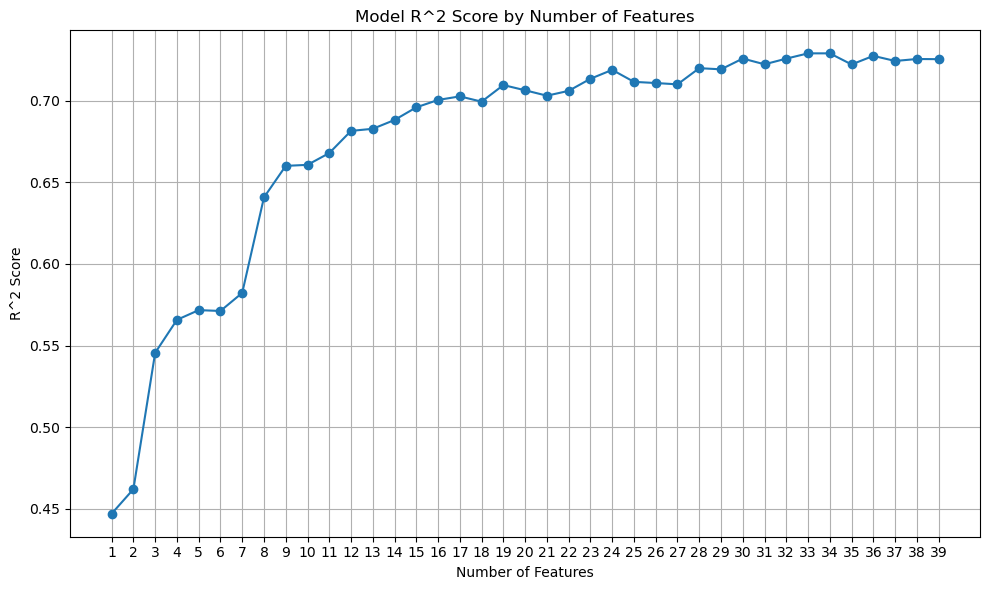

In [10]:
#print the features of features
print(features)
# Load and preprocess data
file_path = r"C:\Users\nstep\TSU\SeniorProject\nashvilleDF.csv"
nashvilleDF = load_data(file_path)
def evaluate_with_features(X_train, y_train, X_test, y_test, features):
    model = HistGradientBoostingRegressor()
    model.fit(X_train[features], y_train)
    y_pred = model.predict(X_test[features])
    return r2_score(y_test, y_pred)

# Assuming features are sorted based on importance (from most to least)
# Features list should NOT include 'price' and 'id'
sorted_features = features

r2_scores = []

#Splitting the data
X = nashvilleDF.drop(columns=['price','id']) # Assuming 'price' is your target variable
y = nashvilleDF['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for i in range(1, len(sorted_features) + 1):
    r2 = evaluate_with_features(X_train, y_train, X_test, y_test, sorted_features[:i])
    r2_scores.append(r2)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(sorted_features) + 1), r2_scores, marker='o', linestyle='-')
plt.xlabel('Number of Features')
plt.ylabel('R^2 Score')
plt.title('Model R^2 Score by Number of Features')
plt.grid(True)
plt.xticks(range(1, len(sorted_features) + 1))
plt.tight_layout()
plt.show()


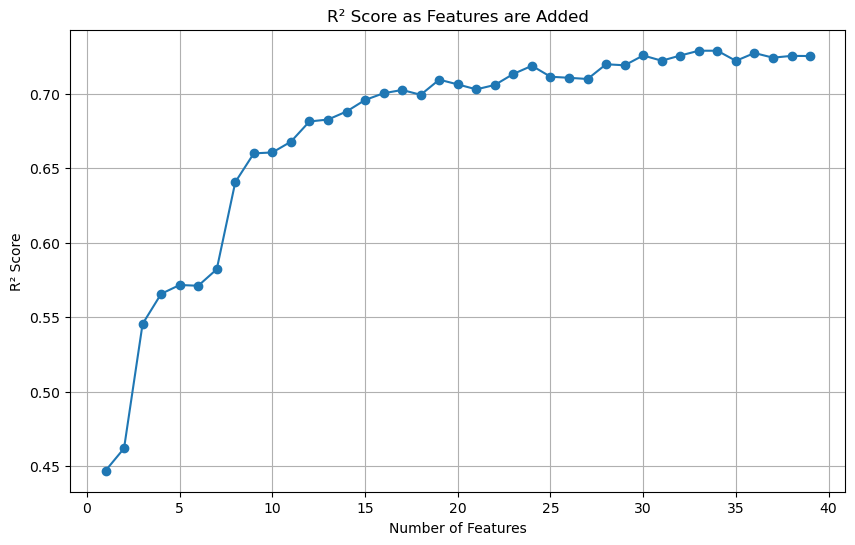

In [6]:
# Step 1: Ensure 'price' and 'id' are not in the features list
features = [f for f in features if f not in ['price', 'id']]

# Step 2: Add specified features to the features list
additional_features = [
    'prop_Entire condo', 'prop_Entire guest suite', 'prop_Entire guesthouse',
    'prop_Entire home', 'prop_Entire rental unit', 'prop_Entire townhouse',
    'prop_Hotel', 'prop_Private room', 'room_Entire home/apt', 'room_Private room'
]
for feat in additional_features:
    if feat not in features:
        features.append(feat)

# Step 3: Evaluate model R² scores for accumulating features
def evaluate_r2_for_features(features_list, X, y):
    r2_scores = []

    for i in range(1, len(features_list) + 1):
        subset_features = features_list[:i]
        X_subset = X[subset_features]

        X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, random_state=42)
        model = HistGradientBoostingRegressor()
        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        r2_scores.append(score)

    return r2_scores

# Get R² scores
r2_scores = evaluate_r2_for_features(features, X, y)

# Plot the scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(features) + 1), r2_scores, marker='o', linestyle='-')
plt.title('R² Score as Features are Added')
plt.xlabel('Number of Features')
plt.ylabel('R² Score')
plt.grid(True)
plt.show()


In [6]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

# Assuming nashvilleDF is already loaded into memory

# Split the data into features and target
X = nashvilleDF.drop(columns=['price'])
y = nashvilleDF['price']

# Initialize the GradientBoostingRegressor
estimator = HistGradientBoostingRegressor()

# List of features sorted by their average rank (as you provided)
features_sorted_by_rank = [item[0] for item in sorted_avg_ranks]

# Start with the first feature ('accommodates')
current_features = [features_sorted_by_rank[0]]

best_score = -np.inf
stop_adding = False
max_features_to_add = 30  # or any other threshold you prefer
added_features_count = 0

while not stop_adding and added_features_count < max_features_to_add:
    scores = []
    
    for feature in features_sorted_by_rank:
        if feature not in current_features:
            # Attempt to add the new feature
            trial_features = current_features + [feature]
            score = cross_val_score(estimator, X[trial_features], y, cv=5).mean()
            scores.append((feature, score))
    
    # Sort the scores and pick the best one
    best_new_feature, new_score = sorted(scores, key=lambda x: x[1], reverse=True)[0]
    
    # If the new score is better, add the feature to the current set
    if new_score > best_score:
        best_score = new_score
        current_features.append(best_new_feature)
        added_features_count += 1
    else:
        # Stop if no improvement in score
        stop_adding = True

print("Selected Features:", current_features)


Selected Features: ['accommodates', 'neighbourhood_cleansed_num', 'minimum_maximum_nights', 'bathrooms', 'minimum_minimum_nights', 'host_acceptance_rate', 'pool', 'reviews_per_month', 'free parking', 'beds', 'host_is_superhost', 'grill', 'resort access', 'private entrance', 'availability_365']


In [39]:
selected_features = current_features + [
    'price', 
    'prop_Entire condo', 
    'prop_Entire guest suite', 
    'prop_Entire guesthouse', 
    'prop_Entire home', 
    'prop_Entire rental unit', 
    'prop_Entire townhouse', 
    'prop_Hotel', 
    'prop_Private room',
    'room_type_num', 
    'room_Entire home/apt', 
    'room_Private room'
]

nashvilleDFcopy = nashvilleDF[selected_features].copy()


# add the column 'wifi from nashvilleDF to nashvilleDFcopy
nashvilleDFcopy['wifi'] = nashvilleDF['wifi']

#write nashvilleDFcopy to csv
nashvilleDFcopy.to_csv(r"C:\Users\nstep\TSU\SeniorProject\nashvilleDFcopy.csv")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDRegressor, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb

subsetdf = nashvilleDFcopy.copy()
df = subsetdf.copy()

def prepare_data(df, target_col='price'):
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    return train_test_split(X, y, test_size=0.2, random_state=42)

def create_models():
    return {
        'GradientBoosting': GradientBoostingRegressor(),
        'RandomForest': RandomForestRegressor(),
        'Linear': LinearRegression(),
        'HistGradientBoosting': HistGradientBoostingRegressor(),
        'DecisionTree': DecisionTreeRegressor(),
        'XGBoost': xgb.XGBRegressor(),
    }

def fit_models(X_train, y_train, models):
    for name, model in models.items():
        model.fit(X_train.astype(float), y_train.astype(float))
    return models

def evaluate_models(X_test, y_test, models):
    results = []
    for name, model in models.items():
        y_pred = model.predict(X_test.astype(float))

        r2 = r2_score(y_test.astype(float), y_pred)
        mse = mean_squared_error(y_test.astype(float), y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test.astype(float), y_pred)

        results.append({
            'Model': name,
            'R2': r2,
            'RMSE': rmse,
            'MSE': mse,
            'MAE': mae
        })
    return pd.DataFrame(results)

def plot_model_performance(results_df):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle('Model Performance Comparison')

    metrics = ['R2', 'RMSE', 'MSE', 'MAE']

    for idx, metric in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]
        results_df.plot(x='Model', y=metric, kind='bar', ax=ax, legend=None)
        ax.set_ylabel(metric)
        ax.set_ylim(bottom=0)
        ax.set_xticklabels(results_df['Model'], rotation=45, ha='right')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def main(df):
    X_train, X_test, y_train, y_test = prepare_data(df)
    X_train.columns = X_train.columns.astype(str)  # Convert all column names to string type
    X_test.columns = X_test.columns.astype(str)    # Convert all column names to string type for consistency
    models = create_models()
    models = fit_models(X_train, y_train, models)
    results_df = evaluate_models(X_test, y_test, models)
    plot_model_performance(results_df)
    table = pd.pivot_table(results_df, index='Model', values=['R2', 'RMSE', 'MSE', 'MAE'])
    print(table)

main(df)

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\nstep\\TSU\\SeniorProject\\nashvilleDFcopy.csv'

In [ ]:
# Step 1: Ensure 'price' and 'id' are not in the features list
features = [f for f in features if f not in ['price', 'id']]

# Step 2: Add specified features to the features list
additional_features = [
    'prop_Entire condo', 'prop_Entire guest suite', 'prop_Entire guesthouse',
    'prop_Entire home', 'prop_Entire rental unit', 'prop_Entire townhouse',
    'prop_Hotel', 'prop_Private room', 'room_Entire home/apt', 'room_Private room'
]
for feat in additional_features:
    if feat not in features:
        features.append(feat)

# Step 3: Evaluate model R² scores for accumulating features
def evaluate_r2_for_features(features_list, X, y):
    r2_scores = []

    for i in range(1, len(features_list) + 1):
        subset_features = features_list[:i]
        X_subset = X[subset_features]

        X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, random_state=42)
        model = HistGradientBoostingRegressor()
        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        r2_scores.append(score)

    return r2_scores

# Get R² scores
r2_scores = evaluate_r2_for_features(features, X, y)

# Plot the scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(features) + 1), r2_scores, marker='o', linestyle='-')
plt.title('R² Score as Features are Added')
plt.xlabel('Number of Features')
plt.ylabel('R² Score')
plt.grid(True)
plt.show()


C:\Users\nstep\AppData\Local\Temp\ipykernel_6468\596880472.py:21: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244) have mixed types. Specify dtype option on impor

Duplicated Columns: []


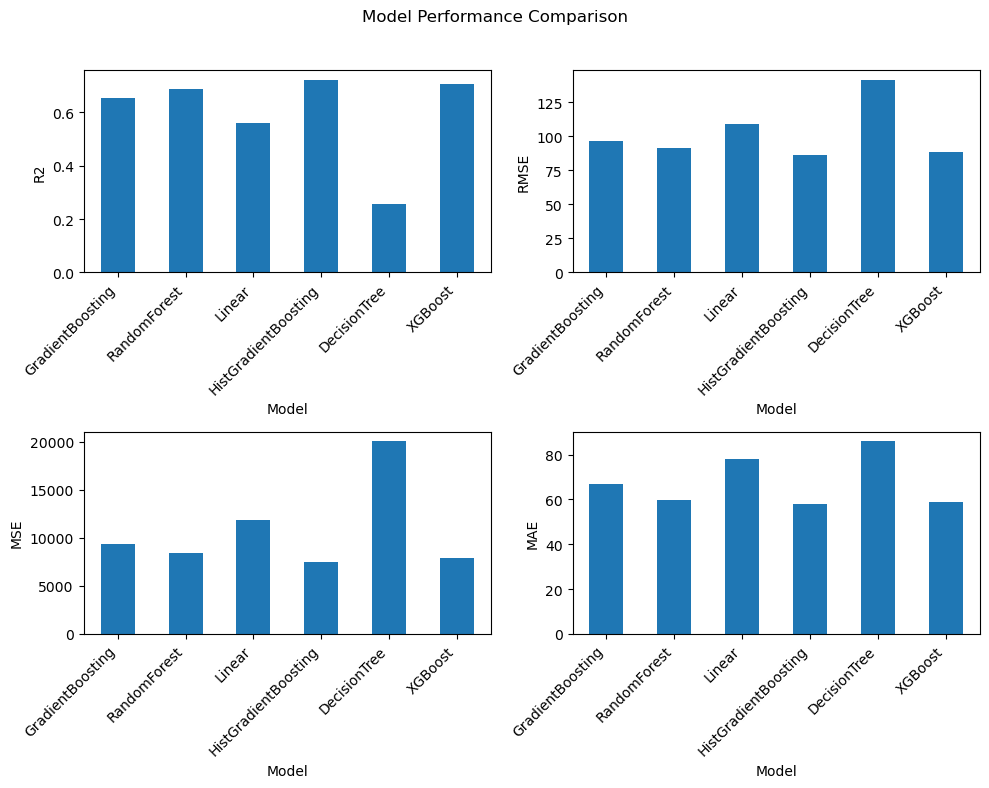

                            MAE           MSE        R2        RMSE
Model                                                              
DecisionTree          86.028118  20049.862507  0.254584  141.597537
GradientBoosting      66.764179   9315.142040  0.653681   96.514983
HistGradientBoosting  57.930811   7499.468203  0.721184   86.599470
Linear                78.030392  11818.379850  0.560615  108.712372
RandomForest          59.678061   8397.407682  0.687800   91.637371
XGBoost               58.938211   7888.771750  0.706710   88.818758


In [42]:
selected_features = features + [
    'price',
    'id', 
    'prop_Entire condo', 
    'prop_Entire guest suite', 
    'prop_Entire guesthouse', 
    'prop_Entire home', 
    'prop_Entire rental unit', 
    'prop_Entire townhouse', 
    'prop_Hotel', 
    'prop_Private room',
    'room_Entire home/apt', 
    'room_Private room'
]

# Load and preprocess data
file_path = r"C:\Users\nstep\TSU\SeniorProject\nashvilleDF.csv"
nashvilleDF = load_data(file_path)


nashvilleDFcopy = nashvilleDF[selected_features].copy()


# add the column 'wifi from nashvilleDF to nashvilleDFcopy
nashvilleDFcopy['wifi'] = nashvilleDF['wifi'].copy()


#write nashvilleDFcopy to csv
nashvilleDFcopy.to_csv(r"C:\Users\nstep\TSU\SeniorProject\nashvilleDFcopy.csv")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDRegressor, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb

subsetdf = nashvilleDFcopy.copy()
df = subsetdf.copy()

def prepare_data(df, target_col='price'):
    X = df.drop([target_col, 'id'], axis=1)
    y = df[target_col]
    return train_test_split(X, y, test_size=0.2, random_state=42)

def create_models():
    return {
        'GradientBoosting': GradientBoostingRegressor(),
        'RandomForest': RandomForestRegressor(),
        'Linear': LinearRegression(),
        'HistGradientBoosting': HistGradientBoostingRegressor(),
        'DecisionTree': DecisionTreeRegressor(),
        'XGBoost': xgb.XGBRegressor(),
    }

def fit_models(X_train, y_train, models):
    for name, model in models.items():
        model.fit(X_train.astype(float), y_train.astype(float))
    return models

def evaluate_models(X_test, y_test, models):
    results = []
    for name, model in models.items():
        y_pred = model.predict(X_test.astype(float))

        r2 = r2_score(y_test.astype(float), y_pred)
        mse = mean_squared_error(y_test.astype(float), y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test.astype(float), y_pred)

        results.append({
            'Model': name,
            'R2': r2,
            'RMSE': rmse,
            'MSE': mse,
            'MAE': mae
        })
    return pd.DataFrame(results)

def plot_model_performance(results_df):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle('Model Performance Comparison')

    metrics = ['R2', 'RMSE', 'MSE', 'MAE']

    for idx, metric in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]
        results_df.plot(x='Model', y=metric, kind='bar', ax=ax, legend=None)
        ax.set_ylabel(metric)
        ax.set_ylim(bottom=0)
        ax.set_xticklabels(results_df['Model'], rotation=45, ha='right')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def main(df):
    X_train, X_test, y_train, y_test = prepare_data(df)
    duplicates = df.columns[df.columns.duplicated()].tolist()
    print(f"Duplicated Columns: {duplicates}")

    X_train.columns = X_train.columns.astype(str)  # Convert all column names to string type
    X_test.columns = X_test.columns.astype(str)    # Convert all column names to string type for consistency
    models = create_models()
    models = fit_models(X_train, y_train, models)
    results_df = evaluate_models(X_test, y_test, models)
    plot_model_performance(results_df)
    table = pd.pivot_table(results_df, index='Model', values=['R2', 'RMSE', 'MSE', 'MAE'])
    print(table)

main(df)

No duplicated columns found.


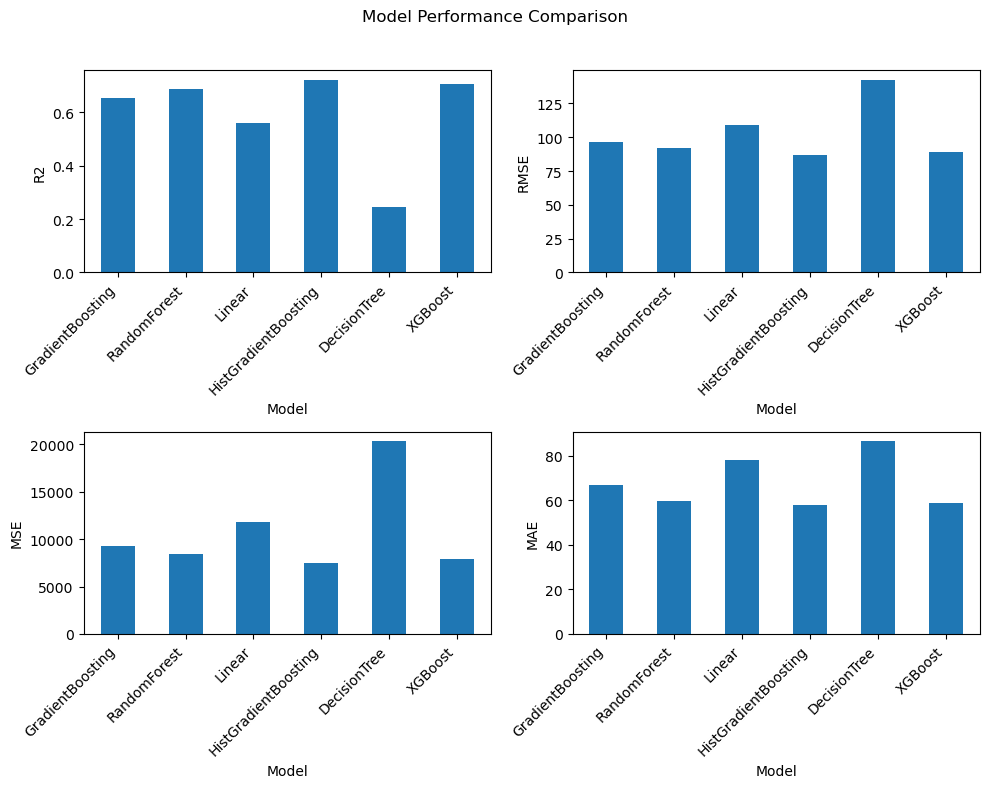

                            MAE           MSE        R2        RMSE
Model                                                              
DecisionTree          86.566579  20309.941761  0.244915  142.512953
GradientBoosting      66.735523   9314.892917  0.653690   96.513693
HistGradientBoosting  57.930811   7499.468203  0.721184   86.599470
Linear                78.030392  11818.379850  0.560615  108.712372
RandomForest          59.834186   8421.921072  0.686889   91.771025
XGBoost               58.938211   7888.771750  0.706710   88.818758


In [32]:

selected_features = features + [
    'price', 
    'prop_Entire condo', 
    'prop_Entire guest suite', 
    'prop_Entire guesthouse', 
    'prop_Entire home', 
    'prop_Entire rental unit', 
    'prop_Entire townhouse', 
    'prop_Hotel', 
    'prop_Private room',
    'room_Entire home/apt', 
    'room_Private room',
    'wifi'
]

nashvilleDFcopy = nashvilleDF[selected_features].copy()



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDRegressor, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb

subsetdf = nashvilleDFcopy.copy()
df = subsetdf.copy()

def prepare_data(df, target_col='price'):
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    return train_test_split(X, y, test_size=0.2, random_state=42)

def create_models():
    return {
        'GradientBoosting': GradientBoostingRegressor(),
        'RandomForest': RandomForestRegressor(),
        'Linear': LinearRegression(),
        'HistGradientBoosting': HistGradientBoostingRegressor(),
        'DecisionTree': DecisionTreeRegressor(),
        'XGBoost': xgb.XGBRegressor(),
    }

def fit_models(X_train, y_train, models):
    for name, model in models.items():
        model.fit(X_train.astype(float), y_train.astype(float))
    return models

def evaluate_models(X_test, y_test, models):
    results = []
    for name, model in models.items():
        y_pred = model.predict(X_test.astype(float))

        r2 = r2_score(y_test.astype(float), y_pred)
        mse = mean_squared_error(y_test.astype(float), y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test.astype(float), y_pred)

        results.append({
            'Model': name,
            'R2': r2,
            'RMSE': rmse,
            'MSE': mse,
            'MAE': mae
        })
    return pd.DataFrame(results)

def check_duplicate_columns(df):
    duplicate_columns = df.columns[df.columns.duplicated()].tolist()
    if duplicate_columns:
        print(f"Duplicated columns found: {duplicate_columns}")
    else:
        print("No duplicated columns found.")




def plot_model_performance(results_df):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle('Model Performance Comparison')

    metrics = ['R2', 'RMSE', 'MSE', 'MAE']

    for idx, metric in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]
        results_df.plot(x='Model', y=metric, kind='bar', ax=ax, legend=None)
        ax.set_ylabel(metric)
        ax.set_ylim(bottom=0)
        ax.set_xticklabels(results_df['Model'], rotation=45, ha='right')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def main(df):
    check_duplicate_columns(df)
    X_train, X_test, y_train, y_test = prepare_data(df)
    X_train.columns = X_train.columns.astype(str)  # Convert all column names to string type
    X_test.columns = X_test.columns.astype(str)    # Convert all column names to string type for consistency
    models = create_models()
    models = fit_models(X_train, y_train, models)
    results_df = evaluate_models(X_test, y_test, models)
    plot_model_performance(results_df)
    table = pd.pivot_table(results_df, index='Model', values=['R2', 'RMSE', 'MSE', 'MAE'])
    print(table)


main(df)

In [19]:
print(len(features))

#print features list
print(features)


30
['accommodates', 'bathrooms', 'neighbourhood_cleansed_num', 'minimum_minimum_nights', 'bedrooms', 'reviews_per_month', 'availability_30', 'minimum_maximum_nights', 'beds', 'pool', 'review_scores_location', 'number_of_reviews', 'host_acceptance_rate', 'free parking', 'maximum_nights', 'review_scores_rating', 'resort access', 'private entrance', 'fireplace', 'cable', 'elevator', 'availability_365', 'maximum_maximum_nights', 'smart lock', 'room_type_num', 'host_is_superhost', 'review_scores_cleanliness', 'grill', 'hot tub', 'review_scores_value']


In [21]:
#make a csv file of nashvilleDFcopy
nashvilleDFcopy.to_csv(r'C:\Users\nstep\TSU\SeniorProject\nashvilleDFcopy.csv', index = False)

In [ ]:
nashvilleDFcopy = nashvilleDF[current_features + ['price']].copy()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDRegressor, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb

subsetdf = nashvilleDFcopy.copy()
df = subsetdf.copy()

def prepare_data(df, target_col='price'):
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    return train_test_split(X, y, test_size=0.2, random_state=42)

def create_models():
    return {
        'GradientBoosting': GradientBoostingRegressor(),
        'RandomForest': RandomForestRegressor(),
        'Linear': LinearRegression(),
        'HistGradientBoosting': HistGradientBoostingRegressor(),
        'DecisionTree': DecisionTreeRegressor(),
        'XGBoost': xgb.XGBRegressor(),
    }

def fit_models(X_train, y_train, models):
    for name, model in models.items():
        model.fit(X_train.astype(float), y_train.astype(float))
    return models

def evaluate_models(X_test, y_test, models):
    results = []
    for name, model in models.items():
        y_pred = model.predict(X_test.astype(float))

        r2 = r2_score(y_test.astype(float), y_pred)
        mse = mean_squared_error(y_test.astype(float), y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test.astype(float), y_pred)

        results.append({
            'Model': name,
            'R2': r2,
            'RMSE': rmse,
            'MSE': mse,
            'MAE': mae
        })
    return pd.DataFrame(results)

def plot_model_performance(results_df):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle('Model Performance Comparison')

    metrics = ['R2', 'RMSE', 'MSE', 'MAE']

    for idx, metric in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]
        results_df.plot(x='Model', y=metric, kind='bar', ax=ax, legend=None)
        ax.set_ylabel(metric)
        ax.set_ylim(bottom=0)
        ax.set_xticklabels(results_df['Model'], rotation=45, ha='right')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def main(df):
    X_train, X_test, y_train, y_test = prepare_data(df)
    X_train.columns = X_train.columns.astype(str)  # Convert all column names to string type
    X_test.columns = X_test.columns.astype(str)    # Convert all column names to string type for consistency
    models = create_models()
    models = fit_models(X_train, y_train, models)
    results_df = evaluate_models(X_test, y_test, models)
    plot_model_performance(results_df)
    table = pd.pivot_table(results_df, index='Model', values=['R2', 'RMSE', 'MSE', 'MAE'])
    print(table)


main(df)

In [11]:
import dowhy
from dowhy import CausalModel
from econml.metalearners import TLearner
from sklearn.ensemble import HistGradientBoostingRegressor

# Dictionary to store causal effects
causal_effects_dict = {}

# For each top feature (let's say top 10 for this example), build a causal model and estimate the effect on price
for feature in X.columns[sorted_idx][-10:]:
    # Initialize the causal model
    model = CausalModel(
        data=nashvilleDF,
        treatment=feature,
        outcome="price",
        common_causes=nashvilleDF.columns.drop([feature, "price"]).tolist()
    )

    # Identify the causal effect
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    
    # Estimate the causal effect using TLearner from EconML
    hgb_regressor = HistGradientBoostingRegressor()
    learner = TLearner(models=(hgb_regressor, hgb_regressor))
    estimate = model.estimate_effect(identified_estimand,
                                    method_name="backdoor.econml.metalearners.TLearner",
                                    control_value=0,
                                    treatment_value=1,
                                    target_units="ate",
                                    method_params={"initialize_models": False,
                                                   "learner": learner})
    
    # Store the estimated causal effect in the dictionary
    causal_effects_dict[feature] = estimate.value

# Print causal effects
for feature, effect in causal_effects_dict.items():
    print(f"{feature}: {effect}")


NameError: name 'sorted_idx' is not defined